Importing Libraries and importing data

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


df = pd.read_csv("cleaned_data_v2.csv") 

display(df)

,PUFC04_SEX,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC09_GRADTECH,PUFC11_WORK,PUFC14_PROCC,PUFC17_NATEM,PUFC18_PNWHRS,PUFC19_PHOURS,PUFC23_PCLASS,PUFC41_WQTR,PUFNEWEMPSTAT
0,Male,49,Married/Living Together,High School Graduate,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,8,24,Self Employed,Yes,Employed
1,Female,61,Married/Living Together,High School Graduate,No,Yes,"Agricultural, forestry and fishery laborers",Short-term,4,8,Without Pay (Family owned Business),Yes,Employed
2,Male,19,Single,High School Graduate,No,Yes,"Agricultural, forestry and fishery laborers",Short-term,8,24,Private Establishment,Yes,Employed
3,Male,48,Married/Living Together,High School - Second Year,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,4,20,Self Employed,Yes,Employed
4,Female,41,Married/Living Together,High School Graduate,No,Yes,Cleaners and helpers,Permanent Job,12,72,Private Household,Yes,Employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92236,Male,34,Married/Living Together,No grade completed,No,Yes,"Market-oriented skilled forestry, fishery and ...",Permanent Job,5,30,Self Employed,Yes,Employed
92237,Female,32,Married/Living Together,No grade completed,No,Yes,Market-oriented skilled agricultural workers,Permanent Job,4,28,Self Employed,Yes,Employed
92238,Male,29,Married/Living Together,High School Graduate,No,Yes,Production and specialized services managers,Permanent Job,8,40,Employer,Yes,Employed
92239,Female,29,Married/Living Together,College - Third Year,No,No,Unknown,Unknown,0,0,Unknown,Unknown,Not in the Labor Force


In [22]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = df.select_dtypes(include=['object']).columns ## filter to object cols

label_encoders = {}

## this encode the columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  

## print the mappings 
for col, le in label_encoders.items():
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print()
    print(col)
    for original, encoded in mapping.items():
        print(f"{original} -> {encoded}")


PUFC04_SEX
Female -> 0
Male -> 1

PUFC06_MSTAT
Annulled -> 0
Divorced/Separated -> 1
Married/Living Together -> 2
Single -> 3
Unknown -> 4
Widowed -> 5

PUFC07_GRADE
College - First Year -> 0
College - Fourth Year -> 1
College - Second Year -> 2
College - Third Year -> 3
Elementary Graduate -> 4
Grade 1 -> 5
Grade 2 -> 6
Grade 3 -> 7
Grade 4 -> 8
Grade 5 -> 9
Grade 6 -> 10
High School - First Year -> 11
High School - Second Year -> 12
High School - Third Year -> 13
High School Graduate -> 14
No grade completed -> 15
Post Baccalaureate -> 16
Post Secondary - First Year -> 17
Post Secondary - Second Year -> 18
Preschool -> 19
Unknown -> 20

PUFC09_GRADTECH
No -> 0
Yes -> 1

PUFC11_WORK
No -> 0
Yes -> 1

PUFC14_PROCC
Administrative and commercial managers -> 0
Agricultural, forestry and fishery laborers -> 1
Armed forces occupations, other ranks -> 2
Assemblers -> 3
Building and related trades workers, excluding electricians -> 4
Business and administration associate professionals -> 5
B

Assign Target Value and Features

In [23]:
X = df.drop(columns=["PUFNEWEMPSTAT"]).values
y = df["PUFNEWEMPSTAT"].values

Normalizing Data: Standerdizes the features to have a mean of 0 and a standard deviation of 1, which helps the neural network converge faster

In [24]:
X = (X - X.mean(axis=0)) / X.std(axis=0)


Train-Test Split: Split data into 70% training and 30% testing
- Stratify ensures the proportion of classes remains balanced between training and testing sets
- Random State ensures reproducibility

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

Convert to PyTorch Tensors for PyTorch processing 
- torch.float32 is sued for features,a nd torch.long is used for classification labels

In [26]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

Data Loader Class
- DataLoader: Efficiently manages batches for training
- Shuffling : Ensures each epoch has a randomized set of samples to prevent the model from learning the order of data
- Batching : Data is divided into smaller, managable chunks using the specified batch size

In [27]:
class DataLoader:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_samples = X.shape[0]

    def get_batch(self, mode='train'):
        indices = np.arange(self.num_samples)
        np.random.shuffle(indices)
        X_shuffled = self.X[indices]
        y_shuffled = self.y[indices]
        X_batches = [X_shuffled[i:i + self.batch_size] for i in range(0, self.num_samples, self.batch_size)]
        y_batches = [y_shuffled[i:i + self.batch_size] for i in range(0, self.num_samples, self.batch_size)]
        return X_batches, y_batches

Neural Network Class 
- Input Size: Number of Features (12)
- Number of Classes : Employed, Unemployed, Not in the LAbor Force, Unknown
- Hidden Layers : Customizable with size [64, 32]


Building Layers
- Linear Layers: Each layer has weights and biases
- ReLU Activation: Common in deep learning, applying non-linearity to capture complex patterns


Forward Pass
- Network Pass: Passes input through all layers
- Softmax: Copnverts oputput logits to probabilities, making it suitable for multi-class classficiation


Prediction
- Argmax: Chooses the class with the highest probability

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes, list_hidden, activation_function='relu'):
        super(NeuralNetwork, self).__init__()
        self.layers = []
        self.activation_function = activation_function

        # Input to first hidden layer
        self.layers.append(nn.Linear(input_size, list_hidden[0]))

        # Hidden layers
        for i in range(len(list_hidden) - 1):
            self.layers.append(nn.ReLU() if activation_function == 'relu' else nn.Sigmoid())
            self.layers.append(nn.Linear(list_hidden[i], list_hidden[i+1]))

        # Output layer
        self.layers.append(nn.ReLU() if activation_function == 'relu' else nn.Sigmoid())
        self.layers.append(nn.Linear(list_hidden[-1], num_classes))

        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x), torch.softmax(self.network(x), dim=1)

    def predict(self, probabilities):
        return torch.argmax(probabilities, dim=1)

Model Initialization : Initializes the nueral network with the specified parameters

In [29]:
input_size = 12
num_classes = 3
list_hidden = [5,10 ]
activation_function = 'relu'

model = NeuralNetwork(input_size, num_classes, list_hidden, activation_function)


In [30]:
print(model.layers[0].weight)

print(model.layers[0].bias)

Parameter containing:
tensor([[-0.2505,  0.2122,  0.2111,  0.1552,  0.0287,  0.2818, -0.2059, -0.2521,
          0.1524,  0.1528,  0.2568, -0.1222],
        [ 0.1010, -0.0451,  0.0353,  0.0108, -0.0658,  0.2560, -0.0099, -0.0645,
         -0.2828,  0.2709,  0.0449, -0.2869],
        [ 0.2712,  0.1366, -0.1240,  0.0563,  0.1158,  0.2770, -0.1471, -0.0788,
         -0.0119,  0.0125,  0.0157, -0.2564],
        [-0.2267,  0.1118,  0.2728,  0.0255,  0.2617,  0.2855,  0.2601,  0.1417,
         -0.0275,  0.1173,  0.1326,  0.2513],
        [ 0.2690, -0.2069,  0.1086, -0.2752, -0.0193,  0.1835,  0.0010, -0.1996,
         -0.1387,  0.0496,  0.0294, -0.0539]], requires_grad=True)
Parameter containing:
tensor([-0.0597, -0.1033, -0.0924, -0.2837,  0.1794], requires_grad=True)


Loss and Optimizer
- CrossEntropyLoss: Suitable for Classification tasks with multiple classes
- Adam Optimizer: Efficient gradient descent with adaptive learning rates

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training Loop
- Epochs: Iterates over the entire dataset multiple times -- start with 50
- Froward Pass: Computes predictions
- Loss Calculation: MEasures error using CrossEntropyLoss
- Backward Pass: Updates weights using gradient descent

In [32]:
import torch

epochs = 100
patience = 10
best_val_loss = float('inf')
wait = 0

batch_size = 32
dataloader = DataLoader(X_train_tensor, y_train_tensor, batch_size)

for epoch in range(epochs):
    X_batches, y_batches = dataloader.get_batch(mode='train')
    total_loss = 0
    model.train()

    for X_batch, y_batch in zip(X_batches, y_batches):
        optimizer.zero_grad()
        outputs, _ = model.forward(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(X_batches)
    
    # Validation
    model.eval()
    val_batches, val_labels = dataloader.get_batch(mode='val')
    val_loss = 0
    
    with torch.no_grad():
        for X_val, y_val in zip(val_batches, val_labels):
            val_outputs, _ = model.forward(X_val)
            loss = criterion(val_outputs, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_batches)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        print("Validation loss improved, saving model...")
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        print(f"No improvement for {wait}/{patience} epochs.")

    if wait >= patience:
        print("Early stopping triggered.")
        break

Epoch [1/100], Train Loss: 0.2176, Val Loss: 0.1050
Validation loss improved, saving model...
Epoch [2/100], Train Loss: 0.0979, Val Loss: 0.0952
Validation loss improved, saving model...
Epoch [3/100], Train Loss: 0.0947, Val Loss: 0.0938
Validation loss improved, saving model...
Epoch [4/100], Train Loss: 0.0938, Val Loss: 0.0932
Validation loss improved, saving model...
Epoch [5/100], Train Loss: 0.0929, Val Loss: 0.0925
Validation loss improved, saving model...
Epoch [6/100], Train Loss: 0.0924, Val Loss: 0.0916
Validation loss improved, saving model...
Epoch [7/100], Train Loss: 0.0919, Val Loss: 0.0925
No improvement for 1/10 epochs.
Epoch [8/100], Train Loss: 0.0917, Val Loss: 0.0911
Validation loss improved, saving model...
Epoch [9/100], Train Loss: 0.0915, Val Loss: 0.0912
No improvement for 1/10 epochs.
Epoch [10/100], Train Loss: 0.0914, Val Loss: 0.0908
Validation loss improved, saving model...
Epoch [11/100], Train Loss: 0.0912, Val Loss: 0.0908
No improvement for 1/10 ep

Predict 
- model.eval(): Ensures dropout and batch normalization are disabled.
- torch.no_grad(): Prevents unnecessary gradient calculations.
- model.forward(X): Gets the raw output from the model (logits or probabilities).
- torch.argmax(outputs, dim=1): Converts the output to class predictions by selecting the class with the highest probability.

In [33]:
def predict(model, X):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        outputs, _ = model.forward(X)
        predicted_classes = torch.argmax(outputs, dim=1)
    return predicted_classes

Evaluation
- Accuracy Calculation: Compares predictions to actual labels.
- classification_report(): Provides a detailed breakdown of Precision, Recall, and F1-score for each class.



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_test_tensor, y_test_tensor):
    # Predict on test data
    y_pred = predict(model, X_test_tensor)

    # Convert tensors to numpy for evaluation
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()

    # Evaluate
    accuracy = accuracy_score(y_test_np, y_pred_np)
    print(f"Accuracy: {accuracy:.4f}")
    print("DONE")

In [51]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Predict on test data
predictions = predict(model, X_test_tensor)
print(predictions)

# Evaluate the model
evaluate_model(model, X_test_tensor, y_test_tensor)

tensor([0, 1, 0,  ..., 1, 0, 0])
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20526
           1       0.85      0.97      0.91      5894
           2       0.60      0.21      0.31      1253

    accuracy                           0.96     27673
   macro avg       0.82      0.73      0.74     27673
weighted avg       0.95      0.96      0.95     27673

DONE


# Section 7: Validation and Error Analysis 

In [52]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(model, X_test_tensor, y_test_tensor):
    # Predict on test data
    y_pred = predict(model, X_test_tensor)

    # Convert tensors to numpy for evaluation
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()

    # Evaluate
    print("Classification Report:")
    print(classification_report(y_test_np, y_pred_np))
    print("DONE")

In [53]:
# Evaluate the model
evaluate_model(model, X_test_tensor, y_test_tensor)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20526
           1       0.85      0.97      0.91      5894
           2       0.60      0.21      0.31      1253

    accuracy                           0.96     27673
   macro avg       0.82      0.73      0.74     27673
weighted avg       0.95      0.96      0.95     27673

DONE


Based on the classification report, for Class 0 (Employed)

- Precision = 1.00 - Every prediction for "Employed" was correct (no false positives).
- Recall = 1.00 - Every actual "Employed" individual was correctly identified (no false negatives).
- F1-score = 1.00 - Perfect classification for this class.


As for Class 1 (Not in the Labor Force)

- Precision = 0.85 - 85% of the predicted "Not in Labor Force" cases were correct. Some false positives exist.
- Recall = 0.97 - 97% of actual "Not in Labor Force" individuals were correctly identified
- F1-score = 0.91 - Good balance between precision and recall.


While for Class 2 (Unemployed)

- Precision = 0.60 - Only 60% of the predicted "Unemployed" cases were correct (high false positives).
- Recall = 0.21 - Only 21% of actual "Unemployed" people were correctly identified (high false negatives).
- F1-score = 0.31 - Poor balance between precision and recall.


From this classification report, we can conclude that the model struggles the most with Class 2 (Unemployed), as it frequently misclassifies individuals in this category as either "Not in the Labor Force" or "Employed." This indicates that the model has difficulty distinguishing unemployed individuals, likely due to class imbalance features between categories.

A confusion matrix will be used identify classes that the model struggles to classify correctly. Misclassified instances indicate which employment statuses are most confused with one another.

In [64]:
y_pred = predict(model, X_test_tensor)

conf_matrix = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[20525     1     0]
 [    0  5723   171]
 [    0   993   260]]


- Class 0 (Employed) is classified almost perfectly with only 1 mistake (classified as Not in Labor Force).

- Class 1 (Not in Labor Force) is mostly well-classified, but 171 individuals were mistakenly labeled as Unemployed.

- Class 2 (Unemployed) is the most misclassified:

    - 993 unemployed individuals were predicted as "Not in Labor Force" (likely because the model struggles to distinguish between these two groups).

    - Only 260 unemployed cases were correctly classified, which aligns with the low recall (0.21) for Class 2 in the classification report.

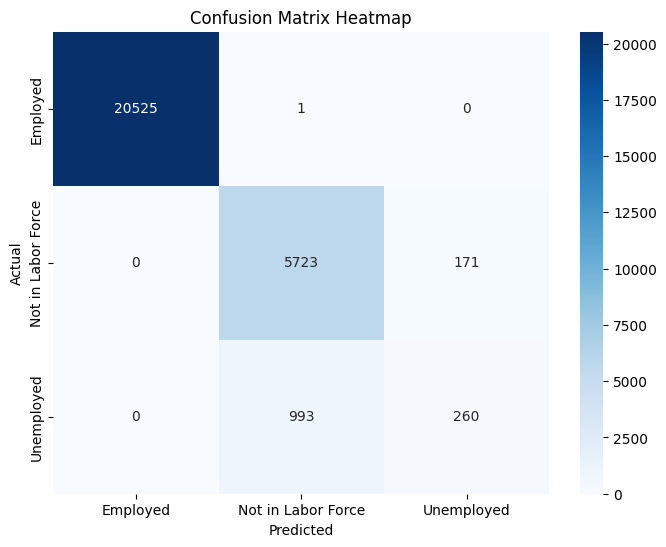

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Employed","Not in Labor Force", "Unemployed"],
            yticklabels=["Employed", "Not in Labor Force", "Unemployed"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()